In [131]:
import pandas as pd
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib_venn
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.stats import multitest

In [2]:
counts_data = pd.read_csv('01. RiboSeq_RNASeq_HCC_counts.tsv', sep='\t', index_col=[0, 1]).T
counts_data['Sample'] = counts_data.index.map(lambda x: x.split('-')[0])
counts_data['Tissue'] = counts_data.index.map(lambda x: x.split('-')[1])
counts_data['Experiment'] = counts_data.index.map(lambda x: x.split('-')[2])
counts_data.set_index(['Sample', 'Tissue', 'Experiment'], drop=True, inplace=True)

# task 1

### 1

использую корреляцию спирмена - она устойчивее к батч-эффектам между типом эксперимента

In [3]:
correlations_data = dict()
for gene_ids, gene_counts in tqdm(counts_data.items()):
    correlations_data[gene_ids] = {
        key: stats.spearmanr(gene_counts[(slice(None), key, 'RPF')], gene_counts[(slice(None), key, 'RNA')])[0]
        for key in ['tumor', 'normal']
    }
correlations = pd.DataFrame(correlations_data).T

/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


### 2

(-1.0, 1.0)

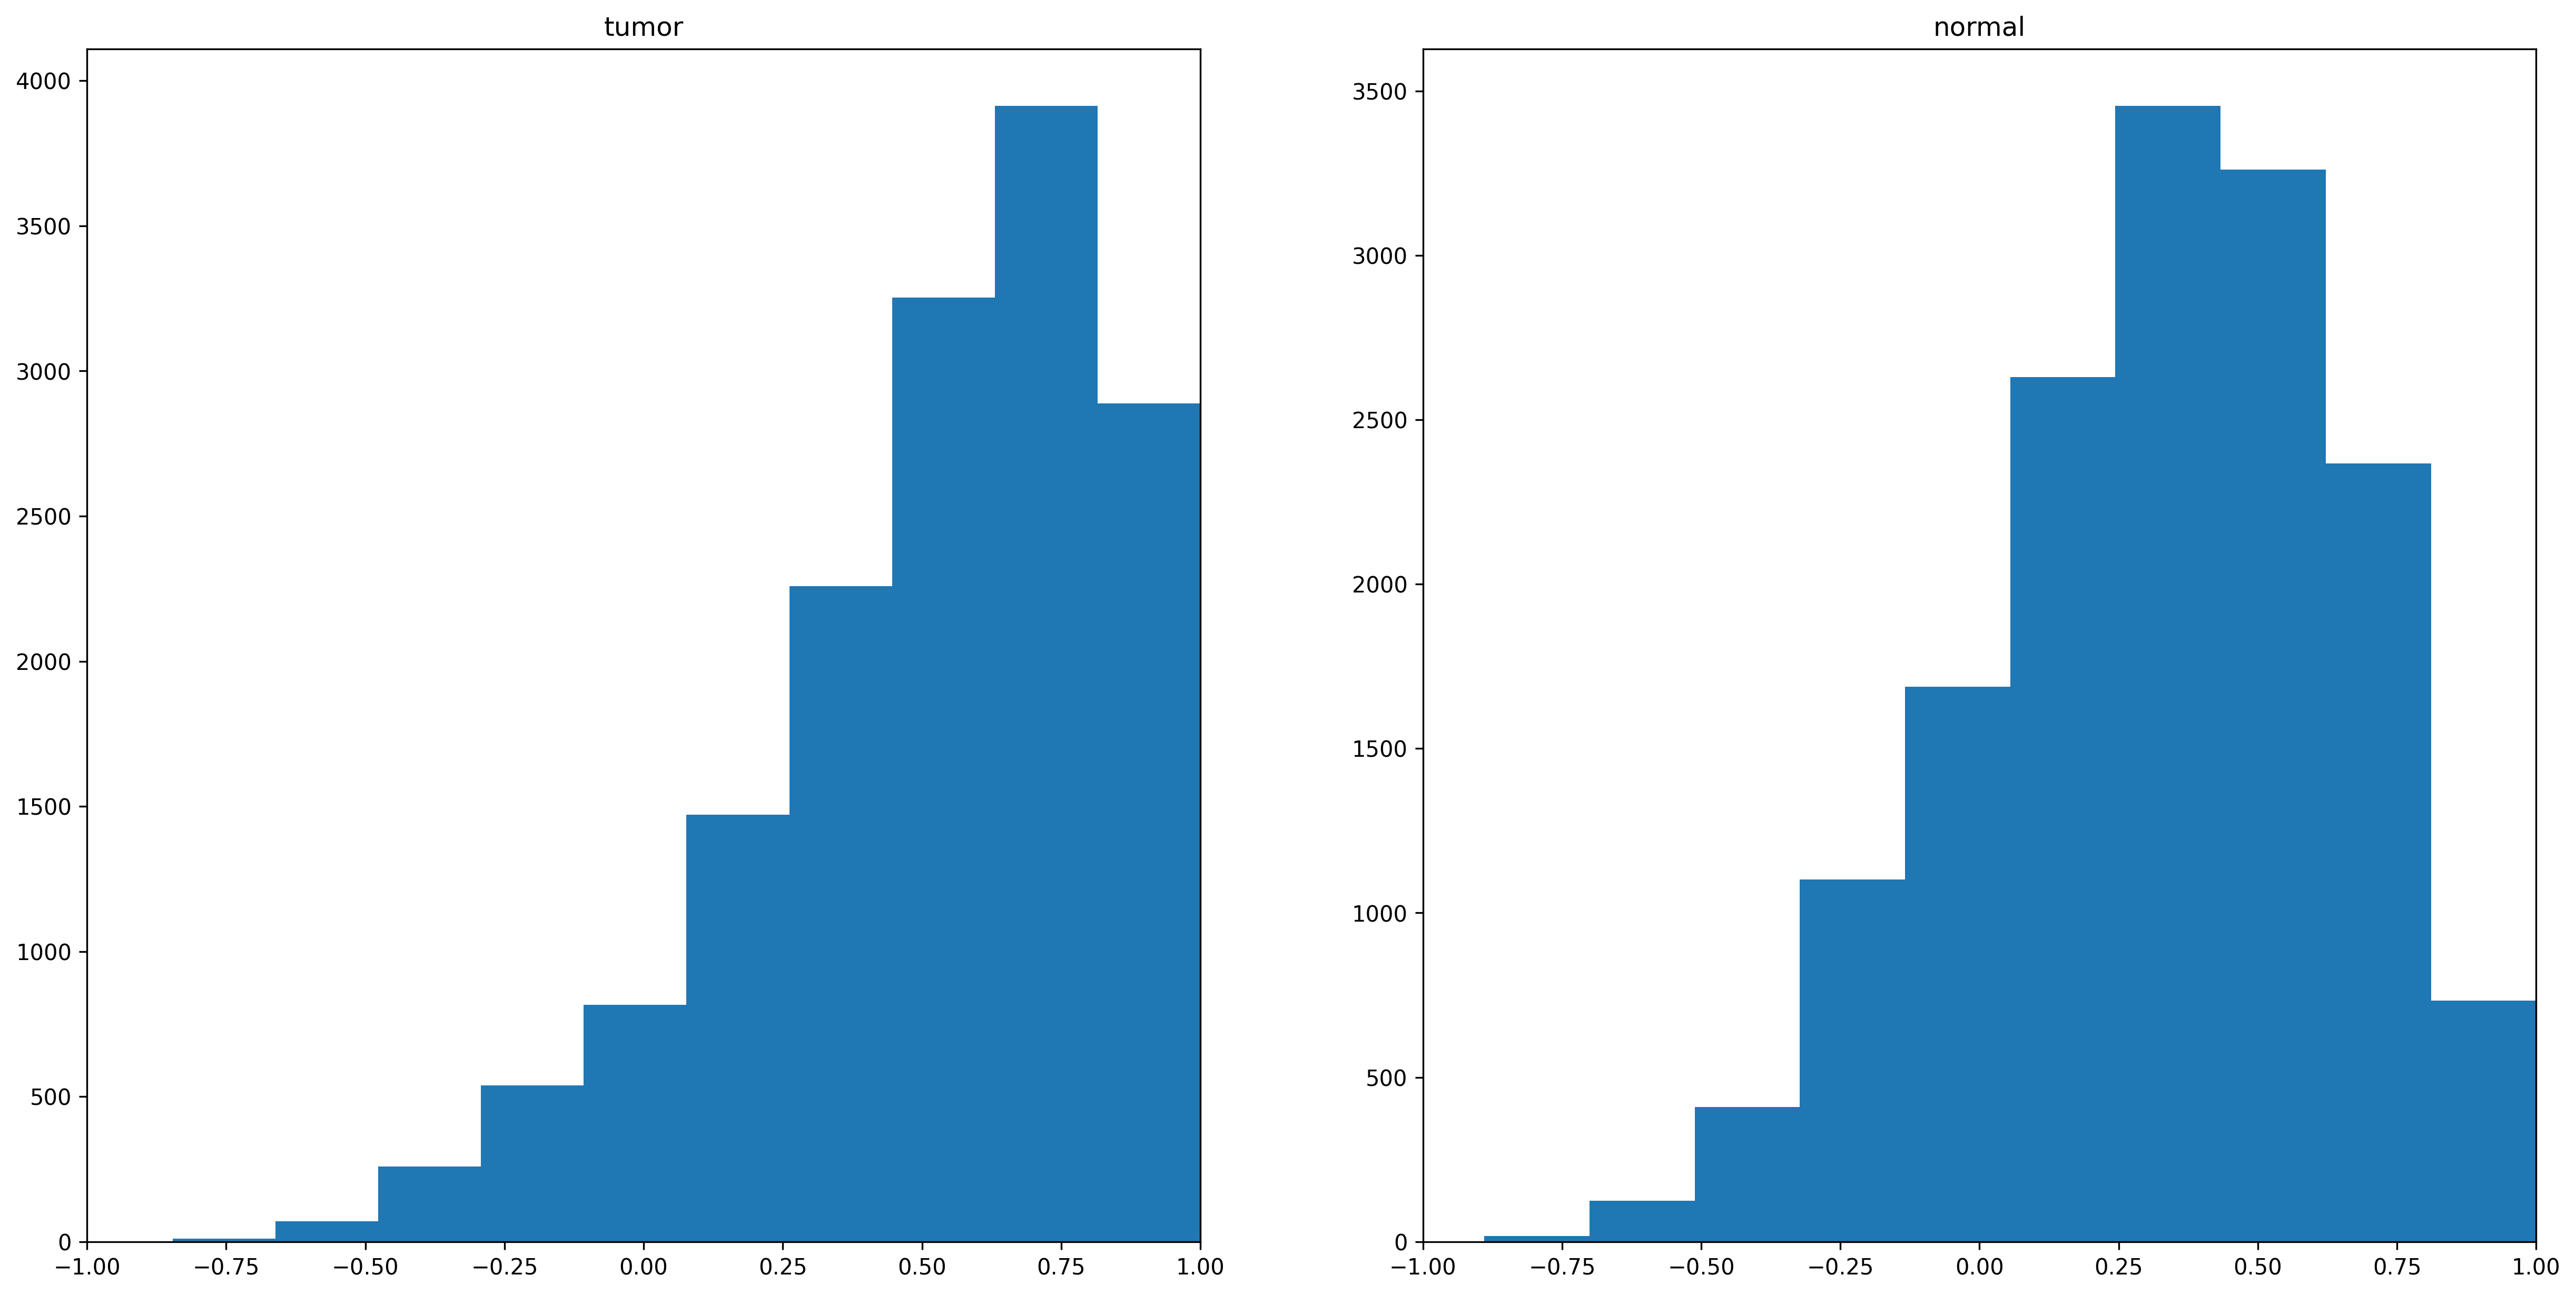

In [4]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=300)
axes[0].hist(correlations['tumor'])
axes[0].set_title('tumor')
axes[0].set_xlim(-1, 1)
axes[1].hist(correlations['normal'])
axes[1].set_title('normal')
axes[1].set_xlim(-1, 1)

In [5]:
side_genes = dict()
for key in ['tumor', 'normal']:
    tissue_data = {
        'most': correlations.loc[
            correlations[key] >= correlations[key].quantile(q=0.99), key
        ].sort_values(ascending=False),
        'least': correlations.loc[
            correlations[key] <= correlations[key].quantile(q=0.01), key
        ].sort_values(ascending=True)
    }
    side_genes[key] = tissue_data

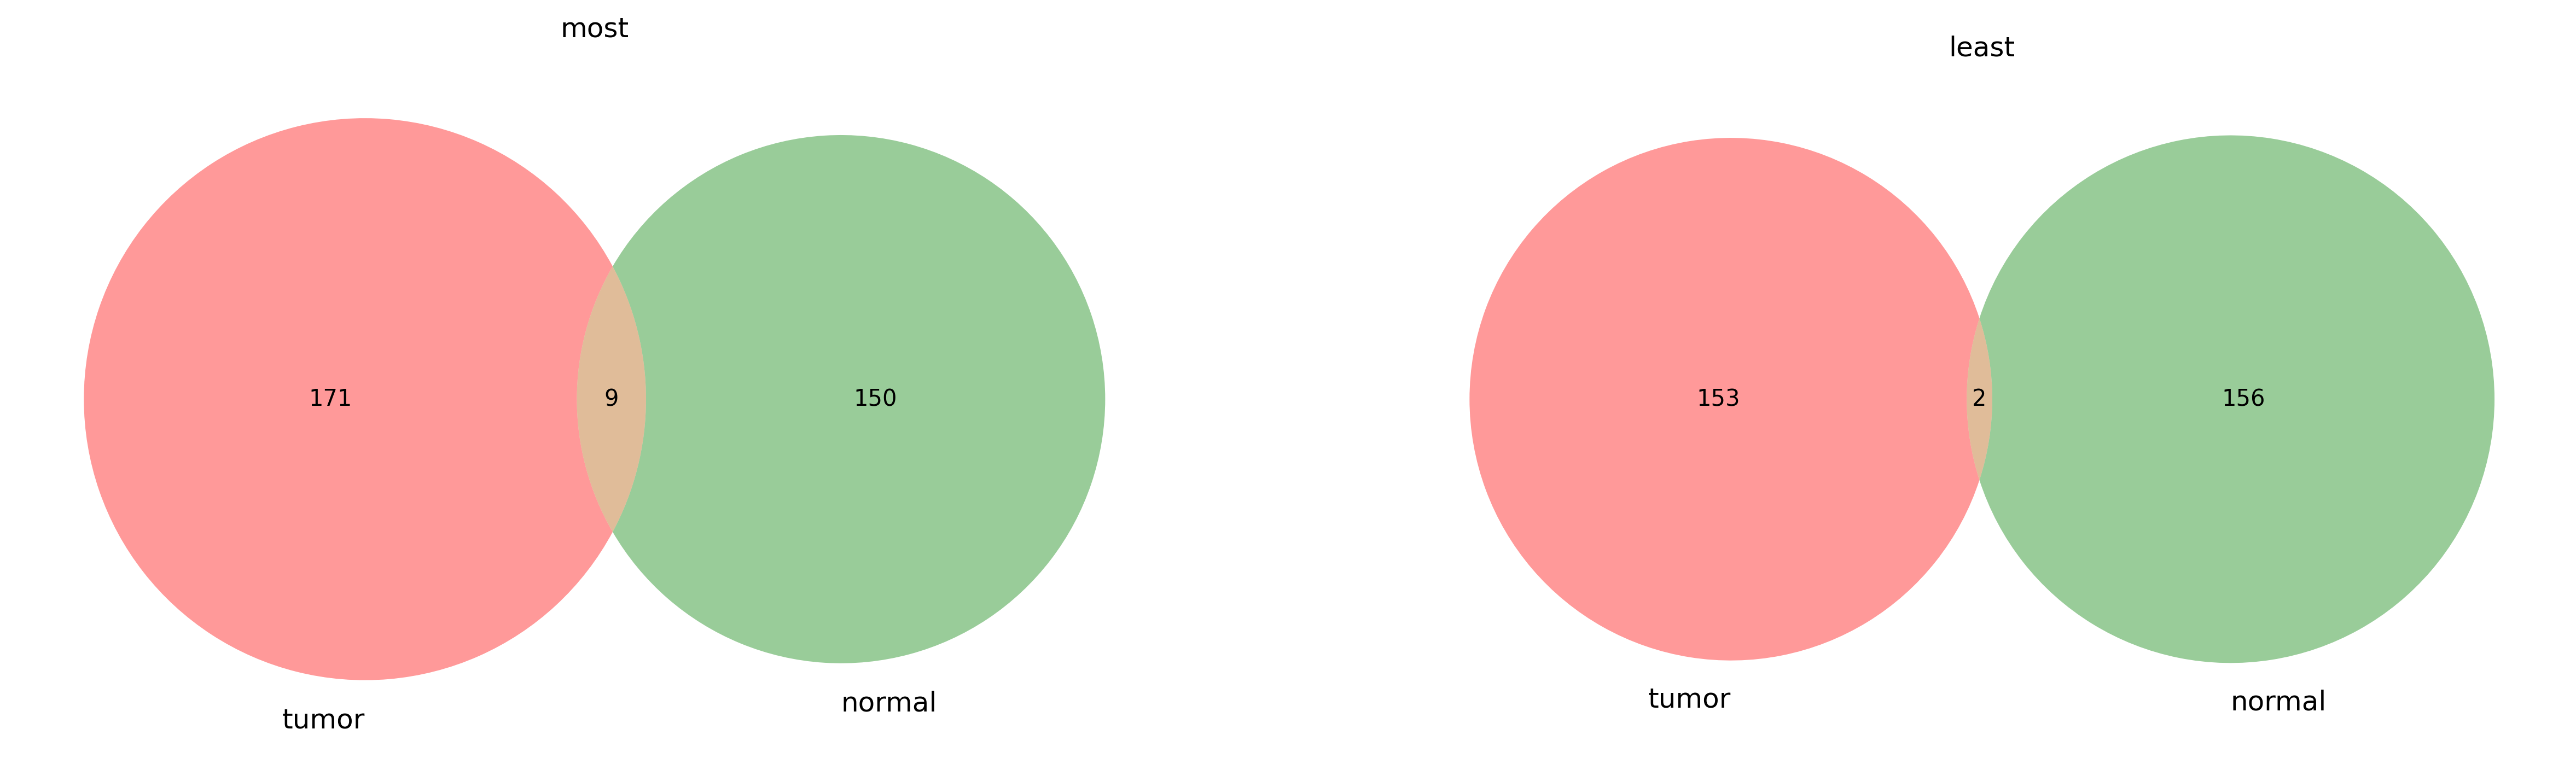

In [6]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=300)
for key, ax in zip(['most', 'least'], axes):
    matplotlib_venn.venn2(
        [set(side_genes['tumor'][key].index.get_level_values(1)),
        set(side_genes['normal'][key].index.get_level_values(1))],
        ax=ax,
        set_labels=['tumor', 'normal']
    )
    ax.set_title(key)

Наборы генов с максимальной и минимальной корреляцией практически не пересекаются между tumor и normal образцами, это может значить что трансляция в опухоли кардинально отличается от транслции в норме (также может быть что полученные наборы отличаются в силу большой доли генов, которые попали в наборы случайно)

Большие по модулю значения отрицательной корреляции скорее всего также обоснованы просто случайностью, тем более что генов с корреляцией < -0.5 почти нет

Большие по модулю значения положительной корреляции могут говорить о том что ген и транскрибируется и транслируется;  
но опять же гены попавшие в квантиль 0.99 могли попасть туда случайно

### 3

In [64]:
de_function = ro.r("""
library(edgeR)
function(counts, tissue) {
    counts_dge = DGEList(counts=counts)
    counts_dge = calcNormFactors(counts_dge, method="RLE")
    design = model.matrix(~tissue)
    counts_dge = estimateGLMCommonDisp(counts_dge, design)
    counts_dge = estimateGLMTrendedDisp(counts_dge, design)
    counts_dge = estimateGLMTagwiseDisp(counts_dge, design)
    strict.disp = pmax(counts_dge$tagwise.dispersion, counts_dge$trended.dispersion, counts_dge$common.dispersion)
    glm.st = glmFit(counts_dge, design, dispersion = strict.disp)
    pv.st = glmLRT(glm.st)
    return(pv.st$table)
}
""")

In [65]:
counts_data_filled = counts_data
for experiment in ['RNA', 'RPF']:
    for tissue in ['normal', 'tumor']:
        mask = (slice(None), tissue, experiment)
        counts_data_filled.loc[mask, :] = counts_data_filled.loc[mask, :].fillna(
            counts_data_filled.loc[mask, :].mean()
        )

de_genes = dict()
with localconverter(ro.default_converter + pandas2ri.converter):
    for experiment in ['RNA', 'RPF']:
        counts_slice = counts_data_filled.loc[
            (slice(None), slice(None), experiment), :
        ].droplevel('geneSymbol', axis=1).T
        tissue = counts_slice.columns.get_level_values('Tissue')
        counts_slice.columns = counts_slice.columns.map(lambda x: f"{x[0]}-{x[1]}")
        de_genes[experiment] = de_function(
            counts_slice,
            pd.Series(index=counts_slice.columns, data=tissue)
        )

In [81]:
for value in de_genes.values():
    value['PValueCorrected'] = multitest.multipletests(value['PValue'], method='bonferroni')[1]

In [90]:
de_genes['RNA'].head()

,logFC,logCPM,LR,PValue,PValueCorrected
ENSG00000000003.14,1.016549,6.466750,4.675196,0.030601,1.0
ENSG00000000005.5,-0.352584,-1.094062,0.085680,0.769742,1.0
ENSG00000000419.12,0.635436,4.545535,1.825584,0.176650,1.0
ENSG00000000457.13,0.302912,4.526909,0.417759,0.518057,1.0
ENSG00000000460.16,1.549294,3.815482,8.359303,0.003837,1.0


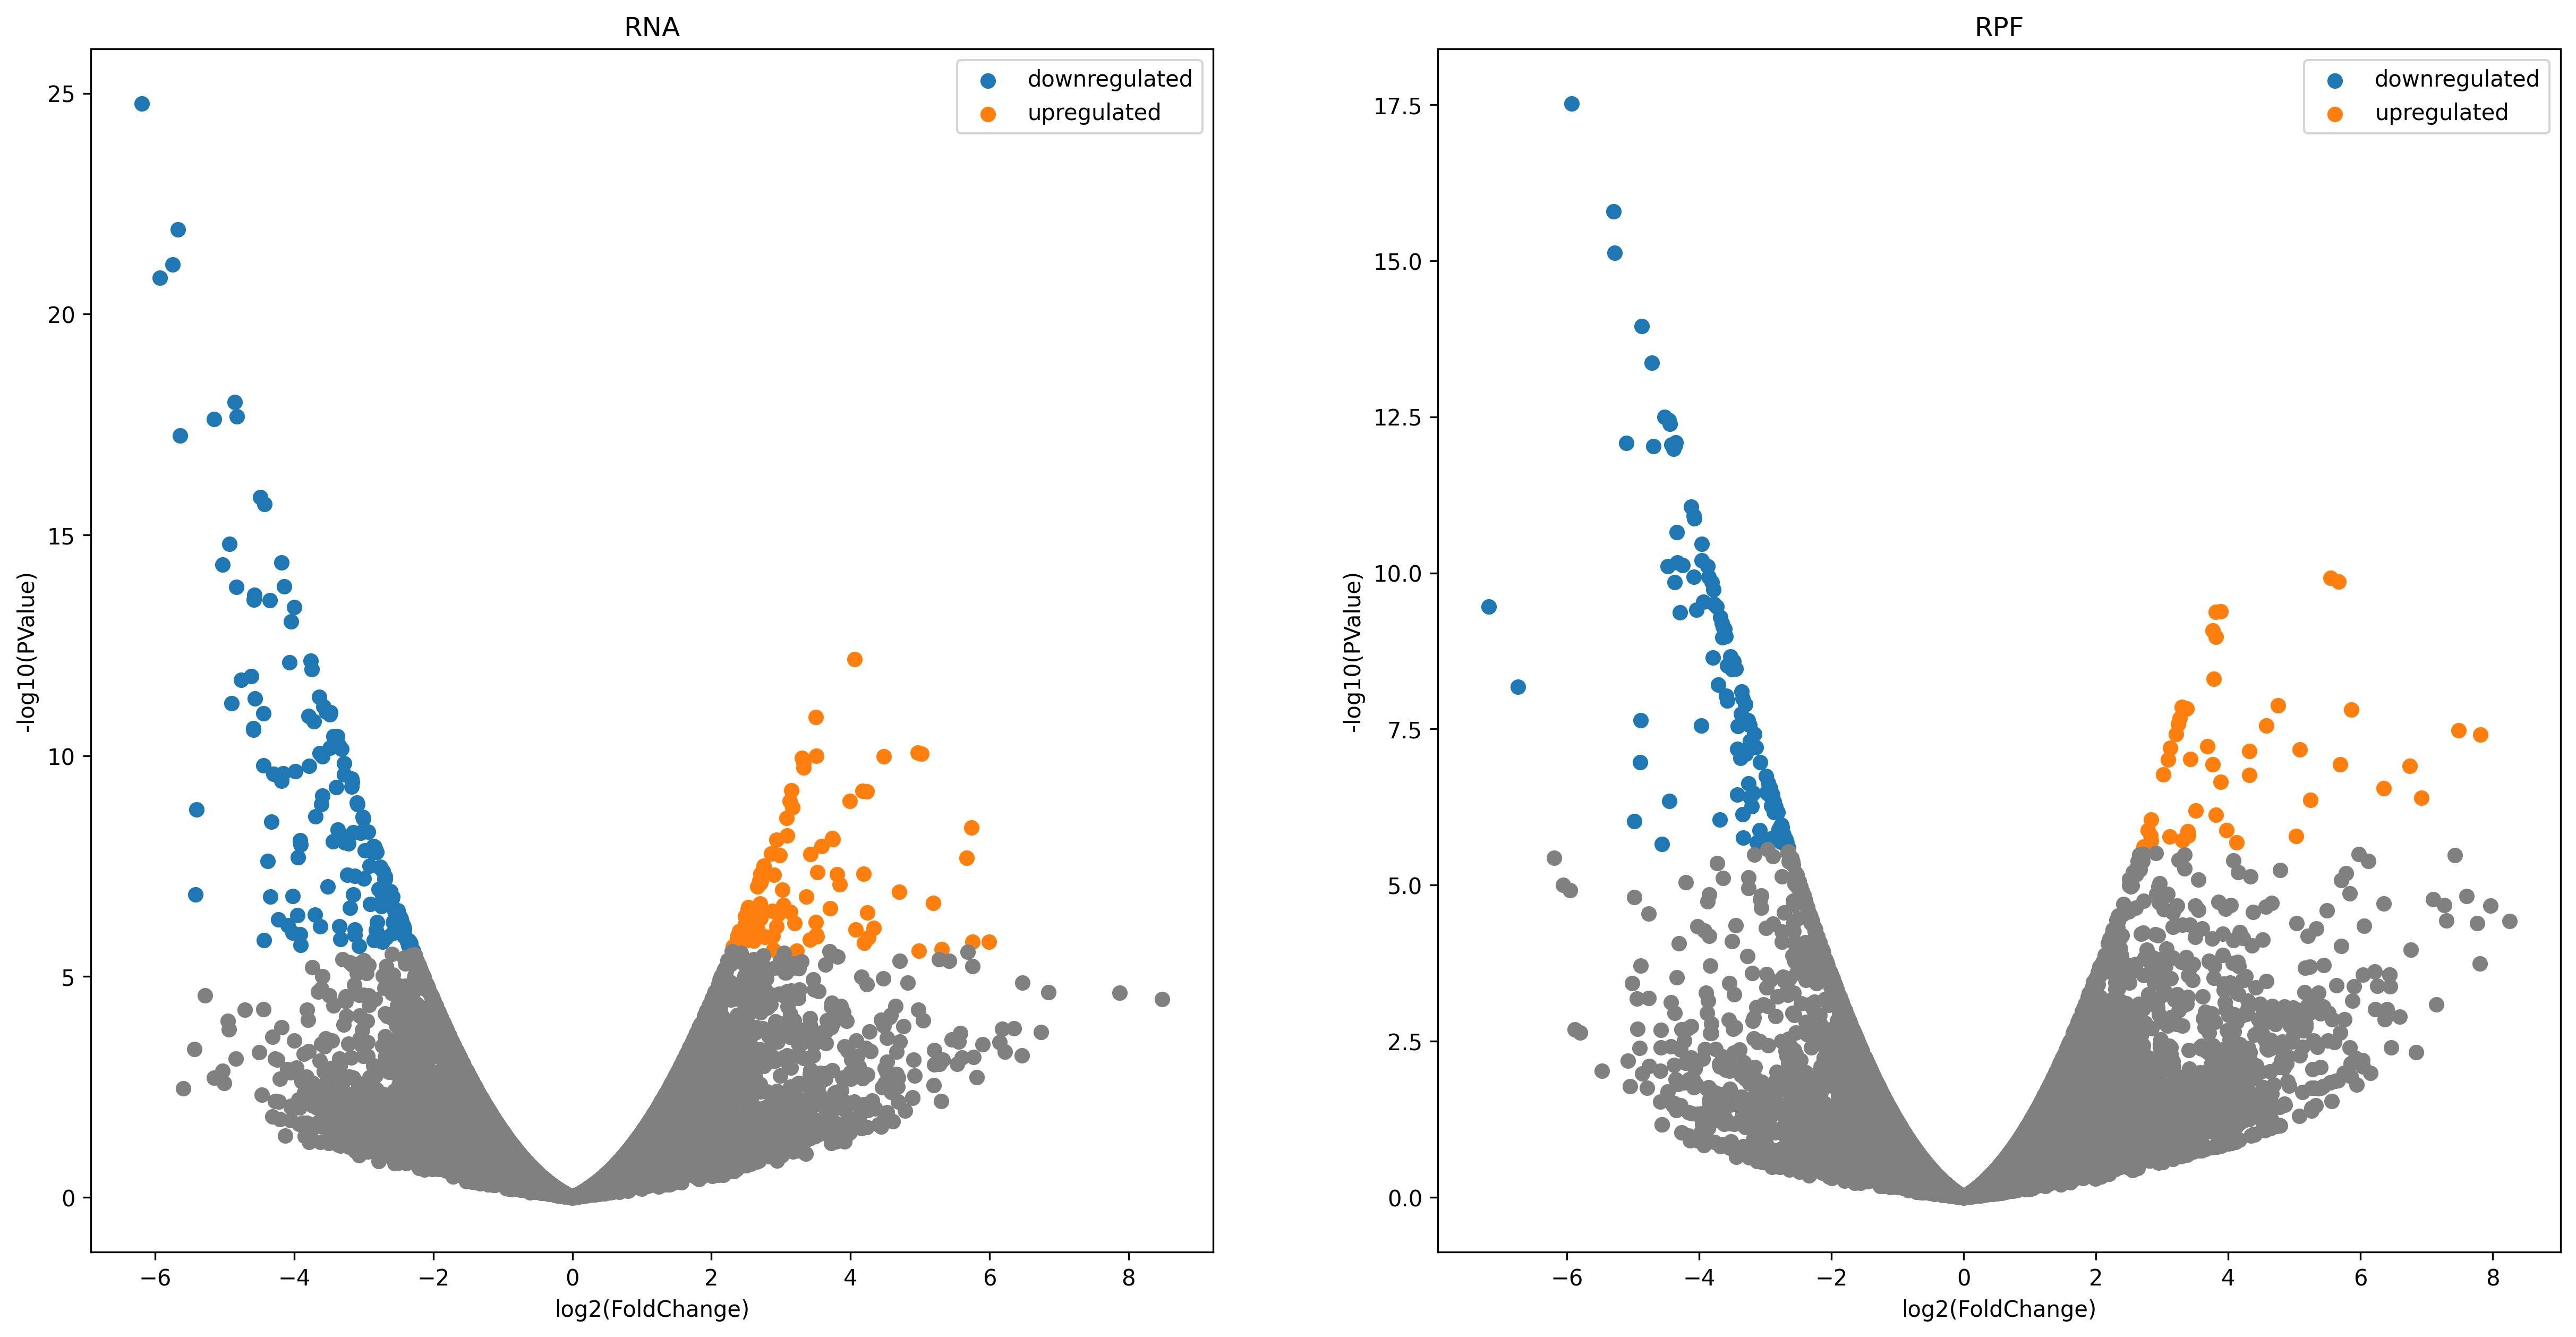

In [97]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=300)
for key, ax in zip(de_genes.keys(), axes):
    mask = (de_genes[key]['logFC'] < 0) & (de_genes[key]['PValueCorrected'] < 0.05)
    ax.scatter(
        de_genes[key].loc[mask, 'logFC'], -1 * np.log10(de_genes[key].loc[mask, 'PValue']),
        label='downregulated'
    )
    mask = (de_genes[key]['logFC'] > 0) & (de_genes[key]['PValueCorrected'] < 0.05)
    ax.scatter(
        de_genes[key].loc[mask, 'logFC'], -1 * np.log10(de_genes[key].loc[mask, 'PValue']),
        label='upregulated'
    )
    mask = (de_genes[key]['PValueCorrected'] >= 0.05)
    ax.scatter(
        de_genes[key].loc[mask, 'logFC'], -1 * np.log10(de_genes[key].loc[mask, 'PValue']), color='grey'
    )
    ax.set_xlabel('log2(FoldChange)')
    ax.set_ylabel('-log10(PValue)')
    ax.set_title(key)
    ax.legend()

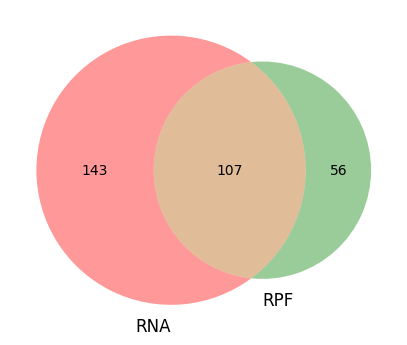

In [105]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), dpi=100)
rna_set = set(de_genes['RNA'].index[de_genes['RNA']['PValueCorrected'] < 0.05])
rpf_set = set(de_genes['RPF'].index[de_genes['RPF']['PValueCorrected'] < 0.05])
matplotlib_venn.venn2(
    [rna_set, rpf_set],
    ax=ax,
    set_labels=['RNA', 'RPF']
)

Text(0.5, 1.0, 'Pvals for genes that are significant in RNA but not in RPF; Pvalue != 1 part: 0.30')

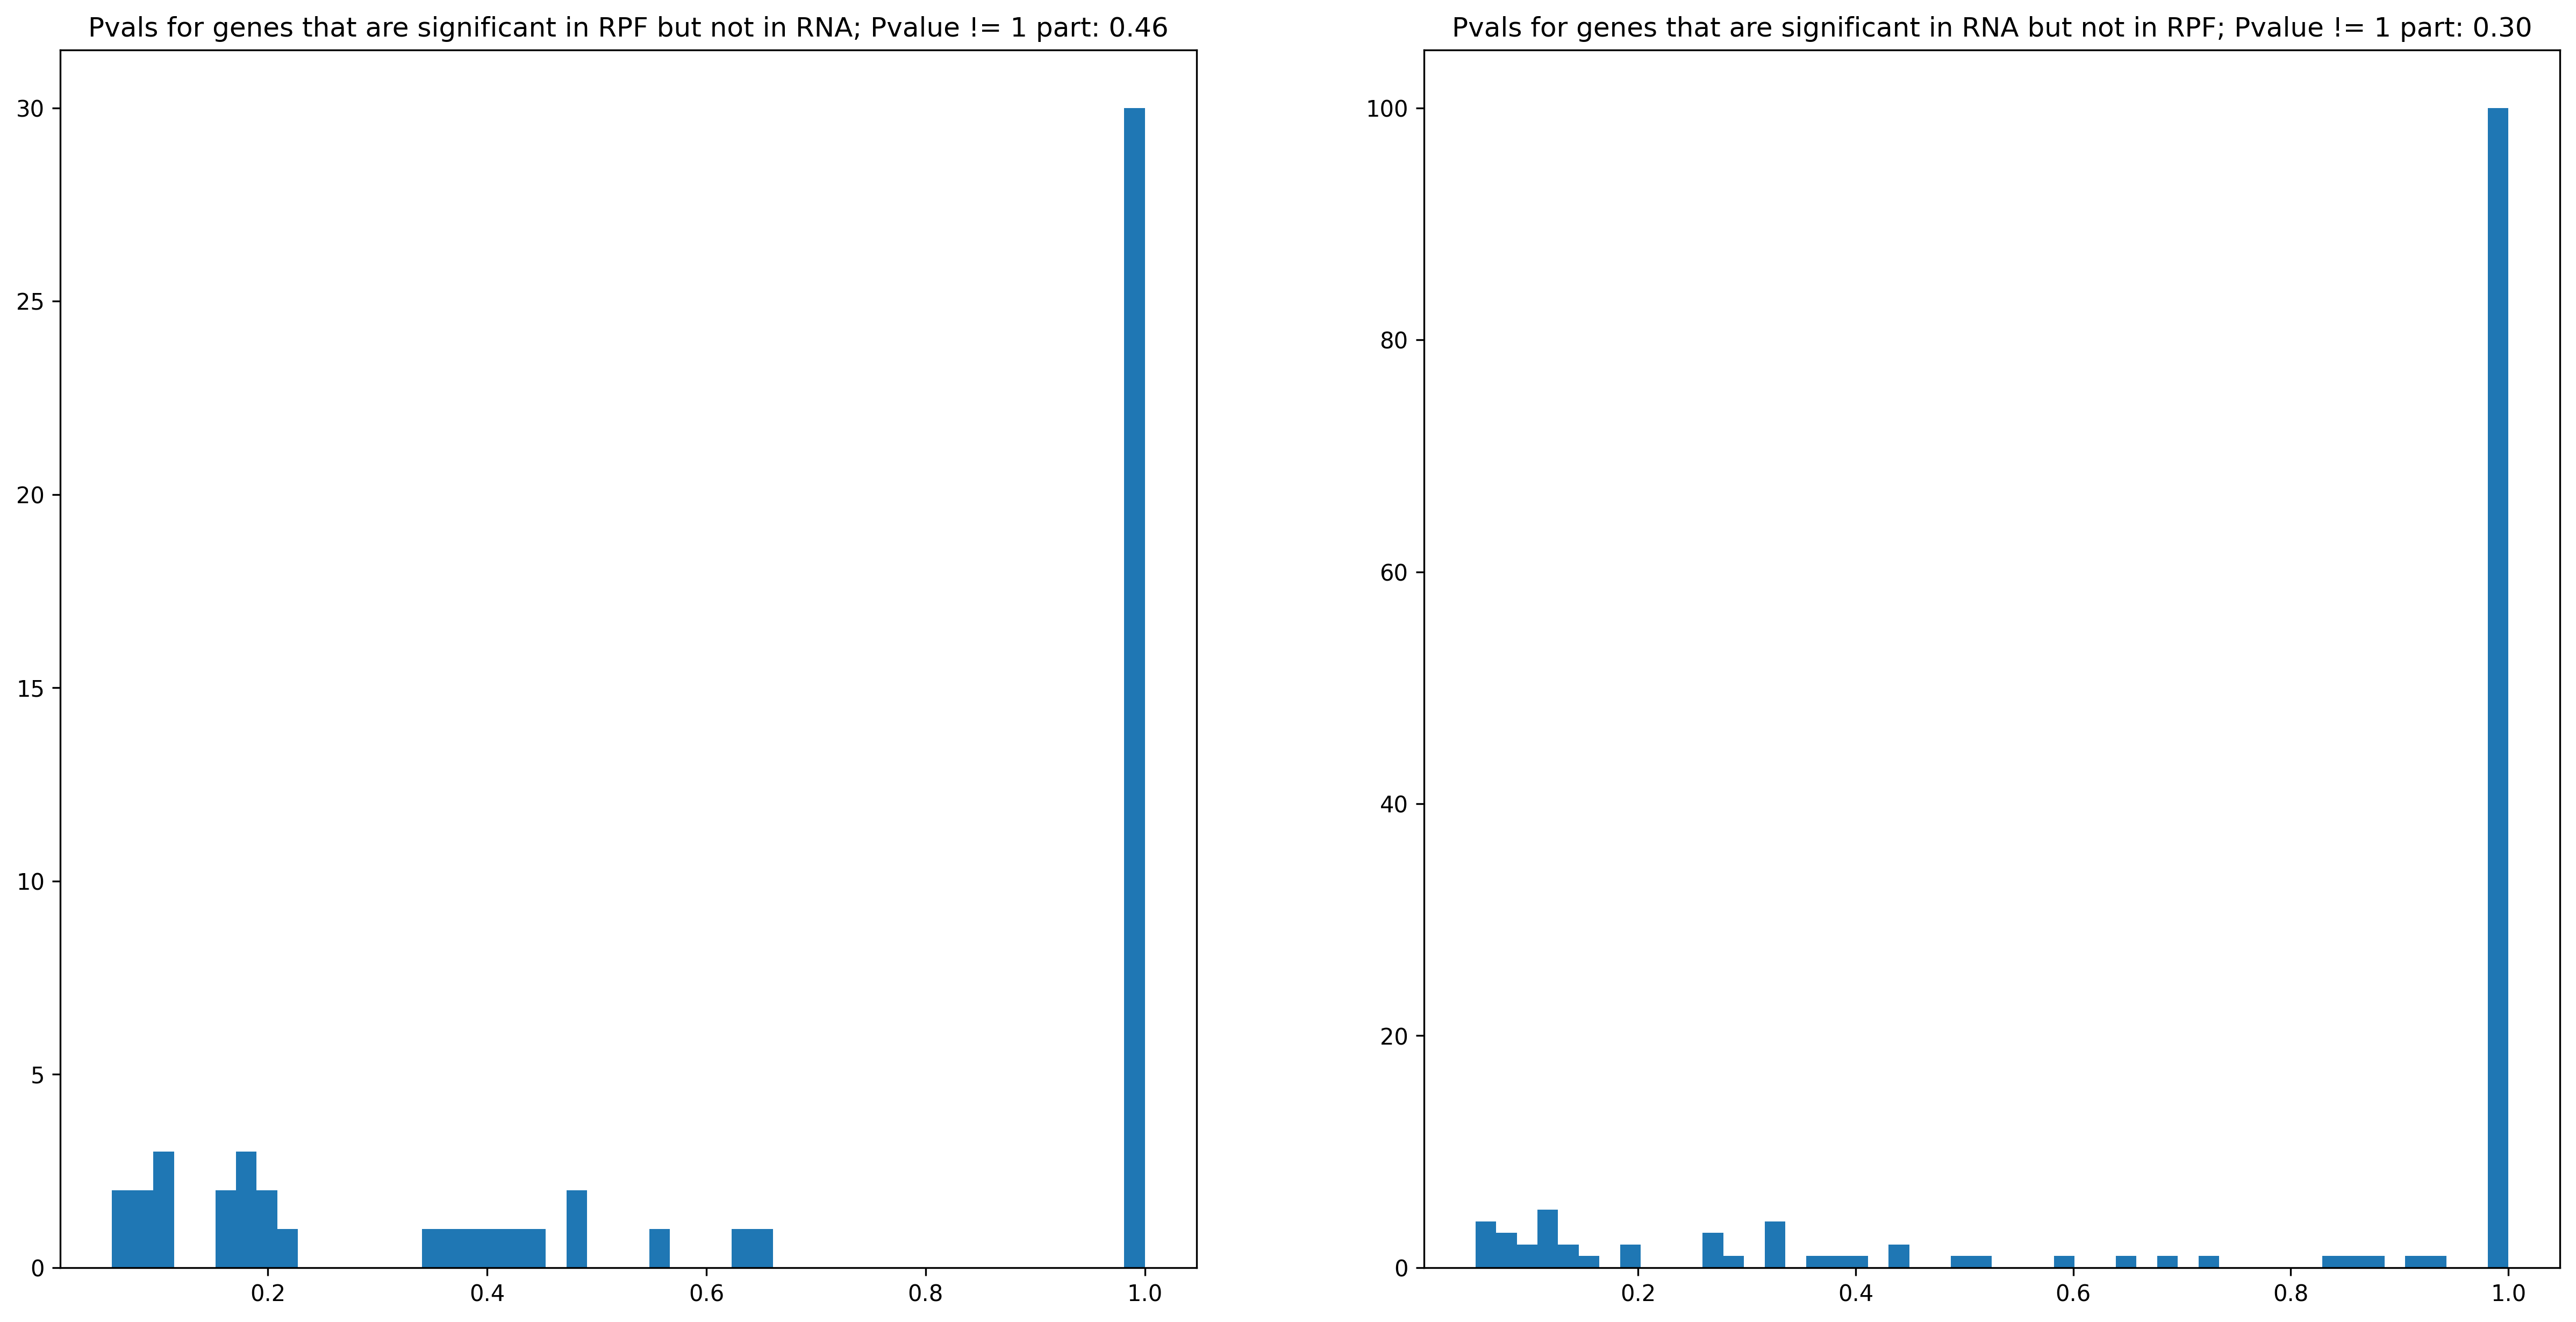

In [122]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi=300)
sample = de_genes['RNA'].loc[rpf_set.difference(rna_set), 'PValueCorrected']
axes[0].hist(sample, bins=50)
axes[0].set_title(f'Pvals for genes that are significant in RPF but not in RNA; Pvalue != 1 part: {(sample != 1).sum() / sample.shape[0]:.2f}')
sample = de_genes['RPF'].loc[rna_set.difference(rpf_set), 'PValueCorrected']
axes[1].hist(sample, bins=50)
axes[1].set_title(f'Pvals for genes that are significant in RNA but not in RPF; Pvalue != 1 part: {(sample != 1).sum() / sample.shape[0]:.2f}')

бОльшая часть дифференциально экспрессированных генов в RPF эксперименте также дифференциально экспрессирована в RNA, что говорит о том что значимая разница в количестве трансриптов может значимо сказываться на скорости трансляции  
Среди генов которые значимо различаются в RPF доля 0.46 имеет != 1 скорректированный pValue; Среди генов RNA 0.3;  
Отсутсвие генов из RPF в RNA можно объяснить тем что трансляция идёт быстрее / замедлена, несмотря на то что количество транскриптов изменено не значимо; отсутсвие генов из RNA в RPF тем, что некоторые гены не транслируются или транслируются медленно (либо трансляция сохраняет скорость при уменьшении числа транскриптов, что не совсем понятно как можно объяснить)

# task 2

### 1

In [1]:
import pandas as pd
import numpy as np
import collections
from Bio import SeqIO
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
forward_reads = pd.read_csv(
    '02. RiboSeq_EColi_track_f.wig', sep='\t', skiprows=[0], names=['position', 'count']
).set_index('position')
backward_reads = pd.read_csv(
    '02. RiboSeq_EColi_track_r.wig', sep='\t', skiprows=[0], names=['position', 'count']
).set_index('position')

In [3]:
records = list(SeqIO.parse("sequence.gb", "genbank"))

In [4]:
plus_strand_genes = {
    item.qualifiers['gene'][0]: item for item in records[0].features 
    if item.strand == 1 and item.type == 'CDS'
}
minus_strand_genes = {
    item.qualifiers['gene'][0]: item for item in records[0].features 
    if item.strand == -1 and item.type == 'CDS'
}

In [5]:
gene_counts = dict()
for gene, gene_data in tqdm(plus_strand_genes.items()):
    gene_counts[gene] = np.sum(np.logical_and(
        forward_reads.index <= gene_data.location.end,
        forward_reads.index >= gene_data.location.start
    ))
for gene, gene_data in tqdm(minus_strand_genes.items()):
    gene_counts[gene] = np.sum(np.logical_and(
        backward_reads.index <= gene_data.location.end,
        backward_reads.index >= gene_data.location.start
    ))

In [6]:
collections.Counter(gene_counts).most_common(1)

[('rpoC', 3952)]

In [7]:
target_reads = forward_reads.loc[np.logical_and(
    forward_reads.index <= plus_strand_genes['rpoC'].location.end,
    forward_reads.index >= plus_strand_genes['rpoC'].location.start
)]

In [40]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 30), dpi=300)
axes[0].bar(target_reads.index - target_reads.index[0], np.log10(target_reads['count']))
axes[0].set_title('rpoC gene log10 coverage per base')
mask = np.logical_and(
    (target_reads.index - target_reads.index[0]) >= 2000,
    (target_reads.index - target_reads.index[0]) <= 2100
)
axes[1].bar(target_reads.index[mask] - target_reads.index[0], target_reads.loc[mask, 'count'])
axes[1].set_title('rpoC gene coverage from 2000 to 2100 bases')
axes[2].hist(np.repeat(target_reads.index, target_reads['count']) - target_reads.index[0], bins=200)
axes[2].set_title('Coverage histogram')

Text(0.5, 1.0, 'Coverage histogram')

На небольшом участке с 2000 до 2100 позиции (2-й график) трудно проследить периодичность в 3 нуклеотида, хотя в некоторых местах её можно уловить между пиками. Покрытие всего гена (3-й график) имеет структуру "леса", т. е. в некоторых регионах в разы больше ридов, чем в среднем. В этом "лесе" трудно проследить периодичность.

In [25]:
sum_count_per_position = collections.Counter()
for gene, gene_data in tqdm(plus_strand_genes.items()):
    gene_reads = forward_reads.loc[(np.logical_and(
        forward_reads.index <= gene_data.location.end,
        forward_reads.index >= gene_data.location.start
    ))]
    if gene_reads.empty:
        continue
    gene_reads.index = gene_reads.index - gene_reads.index[0] + (int(gene_data.qualifiers['codon_start'][0]) - 1)
    sum_count_per_position += collections.Counter(gene_reads['count'].to_dict())

for gene, gene_data in tqdm(minus_strand_genes.items()):
    gene_reads = backward_reads.loc[(np.logical_and(
        backward_reads.index <= gene_data.location.end,
        backward_reads.index >= gene_data.location.start
    ))]
    if gene_reads.empty:
        continue
    gene_reads.index = gene_reads.index - gene_reads.index[0] + (int(gene_data.qualifiers['codon_start'][0]) - 1)
    sum_count_per_position += collections.Counter(gene_reads['count'].to_dict())

In [29]:
sum_count_per_position_array = np.array(list(sum_count_per_position.items()))

In [32]:
sum_count_per_position_array = sum_count_per_position_array[sum_count_per_position_array[:, 0].argsort()]

In [35]:
_, axes = plt.subplots(nrows=3, ncols=1, figsize=(30, 30), dpi=300)
axes[0].bar(sum_count_per_position_array[:, 0], np.log10(sum_count_per_position_array[:, 1]))
axes[0].set_title('Sum gene log10 coverage per base')
mask = np.logical_and(
    sum_count_per_position_array[:, 0] >= 2000,
    sum_count_per_position_array[:, 0] <= 2100
)
axes[1].bar(sum_count_per_position_array[mask, 0], sum_count_per_position_array[mask, 1])
axes[1].set_title('Sum gene coverage from 2000 to 2100 bases')
axes[2].hist(np.repeat(sum_count_per_position_array[:, 0], sum_count_per_position_array[:, 1]), bins=200)
axes[2].set_title('Sum coverage histogram')

Text(0.5, 1.0, 'Sum coverage histogram')

In [39]:
cds_len_sum = 0
for cds in plus_strand_genes.values():
    cds_len_sum += cds.location.end - cds.location.start
for cds in minus_strand_genes.values():
    cds_len_sum += cds.location.end - cds.location.start
mean_cds_len = cds_len_sum / (len(plus_strand_genes) + len(minus_strand_genes))
mean_cds_len

938.11641443539

In [38]:
plus_strand_genes['thrL'].location

FeatureLocation(ExactPosition(189), ExactPosition(255), strand=1)

Периодичность в 3 нуклетида трудно проследить (2-й график), не совсем понятно почему. Как видно из графиков 1 и 3, в среднем покрытие падает экспоненициально, видимо это связано с тем что количество генов с нужной длиной падает с ростом этой длины (в начале есть небольшое "плато", первые несколько сотен оснований есть везде)

### 2

In [59]:
gene_counts_data = pd.Series(gene_counts)

In [61]:
scaling_factor = gene_counts_data.sum() / 1000000
rpm_data = gene_counts_data / scaling_factor
rpkm_data = rpm_data.copy()
for gene, gene_data in tqdm(plus_strand_genes.items()):
    rpkm_data[gene] /= (gene_data.location.end - gene_data.location.start)
        
for gene, gene_data in tqdm(minus_strand_genes.items()):
    rpkm_data[gene] /= (gene_data.location.end - gene_data.location.start)

In [66]:
rpkm_data

thrL    0.673614
thrA    0.689893
thrB    0.598499
thrC    0.729576
yaaX    0.134723
          ...   
ytjB    0.157156
ettA    0.740976
yjjX    0.360522
rob     0.542701
arcA    0.715553
Length: 4295, dtype: float64

In [63]:
rpk_data = gene_counts_data.copy()
for gene, gene_data in tqdm(plus_strand_genes.items()):
    rpk_data[gene] /= (gene_data.location.end - gene_data.location.start) * 0.001

for gene, gene_data in tqdm(minus_strand_genes.items()):
    rpk_data[gene] /= (gene_data.location.end - gene_data.location.start) * 0.001
scaling_factor = rpk_data.sum() / 1000000
tpm_data = rpk_data / scaling_factor

In [64]:
tpm_data

thrL    600.791267
thrA    615.076924
thrB    534.124865
thrC    650.791068
yaaX    119.840794
           ...    
ytjB    139.681985
ettA    661.108488
yjjX    321.427296
rob     484.125063
arcA    638.092706
Length: 4295, dtype: float64

TPM устроен так, что в любом сэмпле того же организма с той же используемой аннотацией сумма TPM по всем генам одинакова, что позволяет непосредственно сравнивать значения TPM одного и того же гена между сэмплами (TPM можно интерпретировать как долю гена в общей экспрессии). RPKM больше подходит для сравнения покрытия разных генов внутри одного сэмпла, т. к. между сэмплами сумма значений RPKM может отличаться

### 3

In [84]:
operon_genes = ['atpI', 'atpB', 'atpE', 'atpF', 'atpH', 'atpA', 'atpG', 'atpD', 'atpC']

In [93]:
(min(minus_strand_genes[gene].location.start for gene in operon_genes), 
 max(minus_strand_genes[gene].location.end for gene in operon_genes))

(ExactPosition(3915552), ExactPosition(3922440))

Text(0, 0.5, 'RPKM')

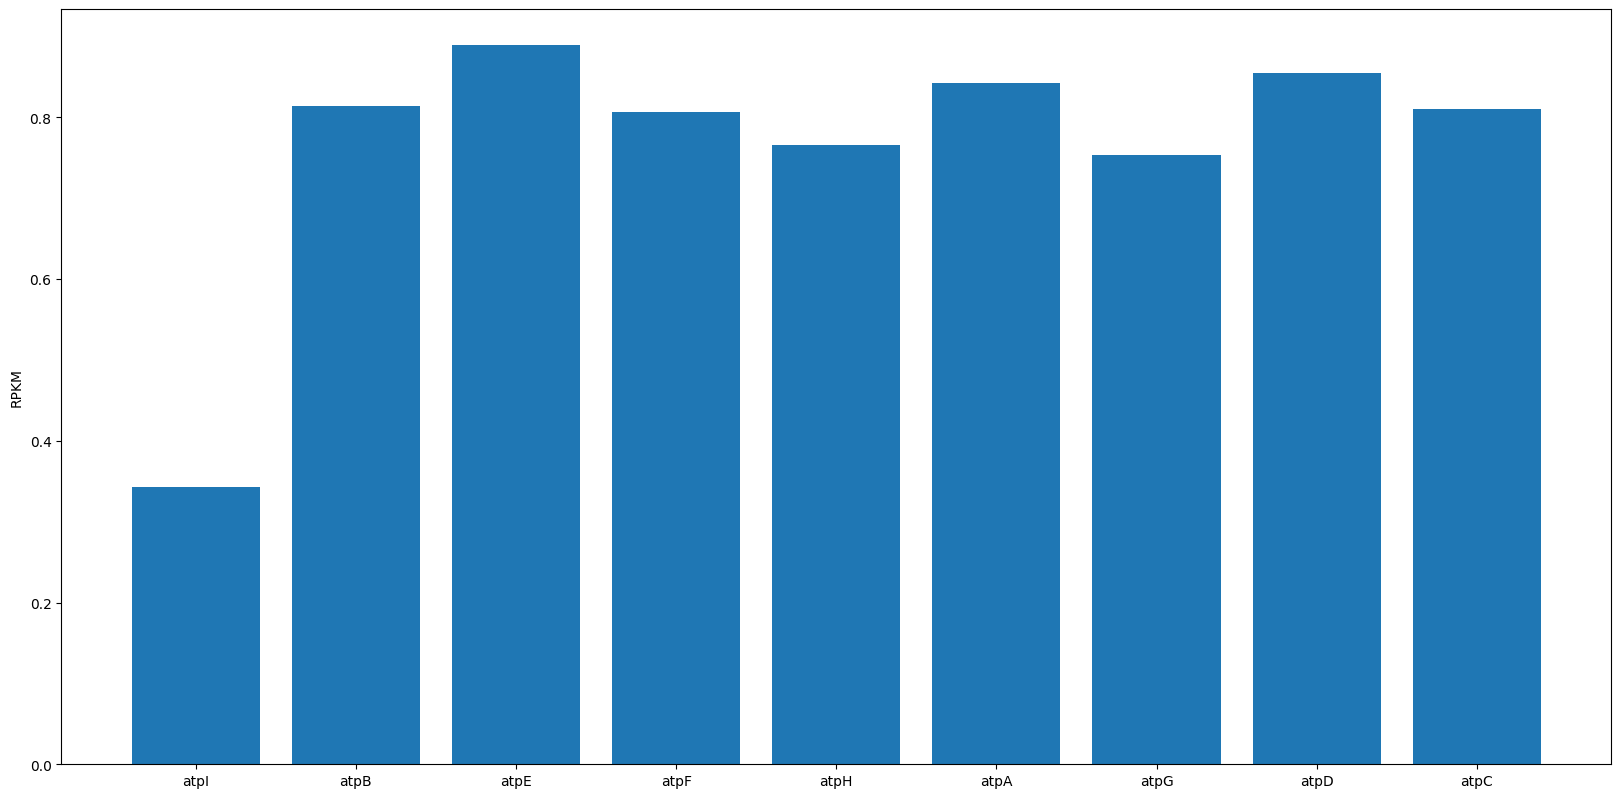

In [89]:
_, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 10), dpi=100)
ax.bar(range(0, len(operon_genes)), [rpkm_data[gene] for gene in operon_genes])
ax.set_xticks(range(0, len(operon_genes)))
ax.set_xticklabels(operon_genes)
ax.set_ylabel('RPKM')

Экспрессия гена atpI явно занижена по сравнению с другими генами оперона. Согласно [uniprot](https://www.uniprot.org/uniprot/P0ABC0), возможная функция этого белка это "to guide the assembly of the membrane sector of the ATPase enzyme complex.". Предполагается что белок, который транслируется из atpI, является по сути катализатором сборки фермента, и не является непосредвенно частью фермента АТФазы. Исходя из этого, можно предположить что этот белок транслируется меньше в силу того что он может катализировать сборку нескольких белковых комплексов АТФазы (не нужно в том количестве, в котором представлены остальные). Вряд ли такую разницу можно заметить в RNA-seq эксперименте, потому что все эти гены транскрибируются синхронно как один оперон.